# Анализ влияния различных факторов на качество сна

Цель данного анализа - проверить какие факторы больше всего влияют на качество моего сна, так как в последнее время я стала значительно хуже высыпаться.  
Основная часть данных была взята из фитнес-браслета, дополнительные показатели собирались вручную по ежедневным наблюдениям.

Загружаем необходимые библиотеки:

In [1]:
%load_ext sql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import json

from statsmodels.stats.multicomp import pairwise_tukeyhsd

### Извлечение и подготовка данных

Та часть данных, которая собиралась вручную, хранится в базе данных Postgre. 
Было бы легче собирать эти данные в csv документы, но мне хотелось попрактиковаться в SQL и подключении базы данных к ноутбуку.

Для использования этих таблиц, устанавливаю подключение к базе данных:

In [2]:
# Postgres username, password, and database name
POSTGRES_ADDRESS = 'localhost' 
POSTGRES_PORT = '5432'
POSTGRES_USERNAME = 'postgres'
POSTGRES_PASSWORD = '****'
POSTGRES_DBNAME = 'health_project'

cnx = create_engine(f'postgresql://{POSTGRES_USERNAME}:{POSTGRES_PASSWORD}@{POSTGRES_ADDRESS}:{POSTGRES_PORT}/{POSTGRES_DBNAME}')

In [3]:
df_day = pd.read_sql_query('''SELECT * FROM health_metrics.day_metrics;''', cnx)
df_day.head()

,date,water_ml,coffee_ml,coffee_after_8pm,tea_ml,tea_after_8pm,last_meal_time,exercise,menstrual_cycle_day,atmospheric_pressure
0,2022-11-03,1000,1000,False,300,False,19:54:00,False,25,758
1,2022-11-04,800,1000,False,300,True,22:35:00,True,26,757
2,2022-11-05,400,1000,False,300,True,23:22:00,False,27,763
3,2022-11-06,1200,1000,False,600,True,19:20:00,True,28,765
4,2022-11-07,600,1500,True,0,False,21:43:00,False,1,762


В первой таблице хранятся метрики, собранные за день:
- количество употребленной воды, т.к. количество потребленной жидкости может влиять на состояние организма;
- количество выпитых кофе и чая, а также информация о том, употребляла ли я их после 20:00, т.к. существует мнение, что кофеин может негативно влиять на сон;
- время последнего приема пищи - предполагается, что поздний прием пищи приводит к ухудшению сна;
- были ли в этот день физические нагрузки (тренировка) - возможно, они могут положительно повлиять на качество сна;
- день менструального цикла - я заметила, что перед началом нового цикла у меня иногда бывает бессонница;
- атмосферное давление - бытует мнение, что погода может влиять на самочувствие, что в свою очередь может влиять на сон.

In [4]:
df_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   date                  177 non-null    object
 1   water_ml              177 non-null    int64 
 2   coffee_ml             177 non-null    int64 
 3   coffee_after_8pm      177 non-null    bool  
 4   tea_ml                177 non-null    int64 
 5   tea_after_8pm         177 non-null    bool  
 6   last_meal_time        177 non-null    object
 7   exercise              177 non-null    bool  
 8   menstrual_cycle_day   177 non-null    int64 
 9   atmospheric_pressure  177 non-null    int64 
dtypes: bool(3), int64(5), object(2)
memory usage: 10.3+ KB


Время последнего приема пищи было загружено как объект, переведем его в формат *datetime*.
Также, сделаем дату индексом для удобства дальнейшего анализа.

In [5]:
df_day['last_meal_time'] = (df_day['date'].astype(str) + ' ' + df_day['last_meal_time'].astype(str)).astype('datetime64[s]')
df_day.set_index('date', drop=True, inplace=True)
df_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 177 entries, 2022-11-03 to 2022-12-21
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype        
---  ------                --------------  -----        
 0   water_ml              177 non-null    int64        
 1   coffee_ml             177 non-null    int64        
 2   coffee_after_8pm      177 non-null    bool         
 3   tea_ml                177 non-null    int64        
 4   tea_after_8pm         177 non-null    bool         
 5   last_meal_time        177 non-null    datetime64[s]
 6   exercise              177 non-null    bool         
 7   menstrual_cycle_day   177 non-null    int64        
 8   atmospheric_pressure  177 non-null    int64        
dtypes: bool(3), datetime64[s](1), int64(5)
memory usage: 10.2+ KB


Во второй таблице хранятся время, в которое я пошла спать, а также субъективная оценка качества сна по 10-балльной шкале (основана на том, ***а.*** насколько легко/тяжело было проснуться утром и ***б.*** насколько сонной я себя чувствовала в первой половине дня)

In [6]:
df_next_day = pd.read_sql_query('''SELECT * FROM health_metrics.next_day_metrics;''', cnx)
df_next_day.set_index('date', drop=True, inplace=True)
df_next_day.head()

,sleep_quality,went_to_bed_time
date,,
2022-11-03,6,2022-11-04 01:31:00
2022-11-04,9,2022-11-05 00:30:00
2022-11-05,10,2022-11-06 01:39:00
2022-11-06,5,2022-11-07 01:19:00
2022-11-07,4,2022-11-08 01:49:00


In [7]:
df_next_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 177 entries, 2022-11-03 to 2023-04-30
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   sleep_quality     177 non-null    int64         
 1   went_to_bed_time  177 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 4.1+ KB


Объединим две таблицы внешним объединением на случай, если я забыла заполнить какой-либо из дней в одной из таблиц:

In [8]:
df_full = df_day.join(df_next_day, how='outer')
df_full.head()

,water_ml,coffee_ml,coffee_after_8pm,tea_ml,tea_after_8pm,last_meal_time,exercise,menstrual_cycle_day,atmospheric_pressure,sleep_quality,went_to_bed_time
date,,,,,,,,,,,
2022-11-03,1000,1000,False,300,False,2022-11-03 19:54:00,False,25,758,6,2022-11-04 01:31:00
2022-11-04,800,1000,False,300,True,2022-11-04 22:35:00,True,26,757,9,2022-11-05 00:30:00
2022-11-05,400,1000,False,300,True,2022-11-05 23:22:00,False,27,763,10,2022-11-06 01:39:00
2022-11-06,1200,1000,False,600,True,2022-11-06 19:20:00,True,28,765,5,2022-11-07 01:19:00
2022-11-07,600,1500,True,0,False,2022-11-07 21:43:00,False,1,762,4,2022-11-08 01:49:00


Данные из фитнес-браслета Xiaomi Mi Band были получены из аккаунта Xiaomi (https://account.xiaomi.com/fe/service/account) во вкладке Privacy.
Запрошенные данные отправляются на электронную почту в виде двух архивов в csv файлами. 
Нужная мне информация хранится в архиве *MiFitness_fr1_data_copy* в файле под названием *MiFitness_hlth_center_aggregated_fitness_data.csv* в следующем виде:

| Classification | Field | Field Description |
|---|---|---|
| Identifier | uid | Mi Account ID |
| Identifier | sid | Data Source Identifier |
| User Activity Data | tag | Primary classification of aggregated fitness data |
| User Activity Data | key | Secondary classification of aggregated fitness data |
| User Activity Data | time | Generation time of aggregated fitness data |
| User Activity Data | update_time | Last modification time of data |
| Exercise and health information | value | Aggregated fitness record |

Загрузим нужные колонки в датафрейм.

In [9]:
df_band = pd.read_csv('MiFitness_hlth_center_aggregated_fitness_data.csv', usecols = ['Tag','Key', 'Time', 'Value'])
df_band.head()

,Tag,Key,Time,Value
0,daily_report,stress,1667174400,"{""avg_stress"":58,""max_stress"":81,""min_stress"":..."
1,daily_report,stress,1667260800,"{""avg_stress"":56,""max_stress"":82,""min_stress"":..."
2,daily_report,stress,1667347200,"{""avg_stress"":59,""max_stress"":83,""min_stress"":..."
3,daily_report,stress,1667433600,"{""avg_stress"":57,""max_stress"":75,""min_stress"":..."
4,daily_report,stress,1667520000,"{""avg_stress"":58,""max_stress"":80,""min_stress"":..."


Переведем время в более читаемый формат:

In [10]:
df_band['Time'] = df_band['Time'].astype('datetime64[s]')
df_band.head()

,Tag,Key,Time,Value
0,daily_report,stress,2022-10-31,"{""avg_stress"":58,""max_stress"":81,""min_stress"":..."
1,daily_report,stress,2022-11-01,"{""avg_stress"":56,""max_stress"":82,""min_stress"":..."
2,daily_report,stress,2022-11-02,"{""avg_stress"":59,""max_stress"":83,""min_stress"":..."
3,daily_report,stress,2022-11-03,"{""avg_stress"":57,""max_stress"":75,""min_stress"":..."
4,daily_report,stress,2022-11-04,"{""avg_stress"":58,""max_stress"":80,""min_stress"":..."


Так как все метрики вертикально склеены в одну таблицу, а все показатели собраны в формате json с разными ключами для разных метрик, каждую метрику придется доставать из таблицы и приводить в нужный вид по отдельности.

Создадим для этого функцию, которая будет принимать строку из датафрейма и нужные ключи и переносить данные из json в отдельные колонки. Аргумент *new_keys* дает возможность задать названия колонок отличное от ключей json.

In [11]:
def parse_data(data, keys, new_keys=None):
    if not new_keys:
        new_keys = keys

    val = json.loads(data.Value)

    for key, nkey in zip(keys, new_keys):
        data[nkey] = val[key]
        data[nkey] = val[key]
        data[nkey] = val[key]

    return data

#### Первая метрика - стресс

In [12]:
df_stress = df_band[(df_band['Key'] == 'stress') & (df_band['Tag'] == 'daily_report')][['Time', 'Value']]
df_stress.head()

,Time,Value
0,2022-10-31,"{""avg_stress"":58,""max_stress"":81,""min_stress"":..."
1,2022-11-01,"{""avg_stress"":56,""max_stress"":82,""min_stress"":..."
2,2022-11-02,"{""avg_stress"":59,""max_stress"":83,""min_stress"":..."
3,2022-11-03,"{""avg_stress"":57,""max_stress"":75,""min_stress"":..."
4,2022-11-04,"{""avg_stress"":58,""max_stress"":80,""min_stress"":..."


Выделим минимальный, средний и максимальный уровень стресса за день при помощи функции выше.
Также сделаем время индексом и переименуем его в *date*, чтобы было в дальнейшем легче объединить этот датафрейм с другими.

In [13]:
keys = ['min_stress', 'avg_stress', 'max_stress']
df_stress = df_stress.apply(parse_data, args=(keys,), axis=1)
df_stress.set_index('Time', drop=True, inplace=True)
df_stress.index.name = 'date'
df_stress.head()

,Value,min_stress,avg_stress,max_stress
date,,,,
2022-10-31,"{""avg_stress"":58,""max_stress"":81,""min_stress"":...",25,58,81
2022-11-01,"{""avg_stress"":56,""max_stress"":82,""min_stress"":...",23,56,82
2022-11-02,"{""avg_stress"":59,""max_stress"":83,""min_stress"":...",49,59,83
2022-11-03,"{""avg_stress"":57,""max_stress"":75,""min_stress"":...",23,57,75
2022-11-04,"{""avg_stress"":58,""max_stress"":80,""min_stress"":...",50,58,80


Объединим эту таблицу с первыми двумя внешним объединением, т.к. с одной стороны, фитнес-браслетом данные начали собираться раньше, чем я начала вручную собирать другие метрики; с другой стороны, был день (или может несколько?) когда я не носила фитнес-браслет.

Остальные метрики будут присоединены через left join.

In [14]:
df_full = df_full.join(df_stress[['min_stress',	'avg_stress', 'max_stress']], how='outer')
df_full.head()

,water_ml,coffee_ml,coffee_after_8pm,tea_ml,tea_after_8pm,last_meal_time,exercise,menstrual_cycle_day,atmospheric_pressure,sleep_quality,went_to_bed_time,min_stress,avg_stress,max_stress
date,,,,,,,,,,,,,,
2022-10-31,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,25.0,58.0,81.0
2022-11-01,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,23.0,56.0,82.0
2022-11-02,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,49.0,59.0,83.0
2022-11-03,1000.0,1000.0,False,300.0,False,2022-11-03 19:54:00,False,25.0,758.0,6.0,2022-11-04 01:31:00,23.0,57.0,75.0
2022-11-04,800.0,1000.0,False,300.0,True,2022-11-04 22:35:00,True,26.0,757.0,9.0,2022-11-05 00:30:00,50.0,58.0,80.0


Делаем то же самое для других метрик.

#### Шаги

***steps*** - пройденные за день шаги

In [15]:
df_steps = df_band[(df_band['Key'] == 'steps') & (df_band['Tag'] == 'daily_report')][['Time', 'Value']]
df_steps = df_steps.apply(parse_data, args=(['steps'],), axis=1)
df_steps.set_index('Time', drop=True, inplace=True)
df_steps.index.name = 'date'
df_steps.head()

,Value,steps
date,,
2022-10-30,"{""calories"":17,""distance"":86,""steps"":153}",153
2022-10-31,"{""calories"":59,""distance"":306,""steps"":543}",543
2022-11-01,"{""calories"":20,""distance"":58,""steps"":123}",123
2022-11-02,"{""calories"":211,""distance"":517,""steps"":1028}",1028
2022-11-03,"{""calories"":37,""distance"":115,""steps"":237}",237


#### SPO_2

***avg_spo2*** - средний за день уровень насыщения крови кислородом

In [16]:
df_spo = df_band[(df_band['Key'] == 'spo2') & (df_band['Tag'] == 'daily_report')][['Time', 'Value']]
df_spo = df_spo.apply(parse_data, args=(['avg_spo2'],), axis=1)
df_spo.set_index('Time', drop=True, inplace=True)
df_spo.index.name = 'date'
df_spo.head() 

,Value,avg_spo2
date,,
2022-10-30,"{""avg_spo2"":97,""lack_spo2_count"":0,""max_spo2"":...",97
2022-10-31,"{""avg_spo2"":94,""lack_spo2_count"":0,""max_spo2"":...",94
2022-11-01,"{""avg_spo2"":92,""lack_spo2_count"":0,""max_spo2"":...",92
2022-11-02,"{""avg_spo2"":93,""lack_spo2_count"":0,""max_spo2"":...",93
2022-11-03,"{""avg_spo2"":93,""lack_spo2_count"":0,""max_spo2"":...",93


#### Частота сердцебиения

***min_heart_rate*** - минимальный пульс за день  
***avg_heart_rate*** - средний пульс за день  
***max_heart_rate*** - максимальный пульс за день  

In [17]:
df_pulse = df_band[(df_band['Key'] == 'heart_rate') & (df_band['Tag'] == 'daily_report')][['Time', 'Value']]

keys = ['min_hr', 'avg_hr', 'max_hr']
new_keys = ['min_heart_rate', 'avg_heart_rate', 'max_heart_rate']
df_pulse = df_pulse.apply(parse_data, args=(keys, new_keys), axis=1)

df_pulse.set_index('Time', drop=True, inplace=True)
df_pulse.index.name = 'date'
df_pulse.head()

,Value,min_heart_rate,avg_heart_rate,max_heart_rate
date,,,,
2022-10-30,"{""abnormal_hr_count"":0,""avg_hr"":100,""avg_rhr"":...",78,100,113
2022-10-31,"{""abnormal_hr_count"":0,""avg_hr"":87,""avg_rhr"":8...",64,87,131
2022-11-01,"{""abnormal_hr_count"":0,""avg_hr"":85,""avg_rhr"":8...",70,85,130
2022-11-02,"{""abnormal_hr_count"":0,""avg_hr"":94,""avg_rhr"":9...",66,94,169
2022-11-03,"{""abnormal_hr_count"":0,""avg_hr"":91,""avg_rhr"":8...",73,91,131


#### Калории

***calories*** - сожженные за день калории

In [18]:
df_calories = df_band[(df_band['Key'] == 'calories') & (df_band['Tag'] == 'daily_report')][['Time', 'Value']]
df_calories = df_calories.apply(parse_data, args=(['calories'],), axis=1)
df_calories.set_index('Time', drop=True, inplace=True)
df_calories.index.name = 'date'
df_calories.head()

,Value,calories
date,,
2022-10-30,"{""calories"":65}",65
2022-10-31,"{""calories"":579}",579
2022-11-01,"{""calories"":184}",184
2022-11-02,"{""calories"":851}",851
2022-11-03,"{""calories"":470}",470


#### Сон

In [19]:
df_sleep = df_band[(df_band['Key'] == 'sleep') & (df_band['Tag'] == 'daily_report')][['Time', 'Value']]
df_sleep.head()

,Time,Value
719,2022-10-31,"{""avg_hr"":83,""avg_spo2"":94,""day_sleep_evaluati..."
720,2022-11-01,"{""avg_hr"":82,""avg_spo2"":91,""day_sleep_evaluati..."
721,2022-11-02,"{""avg_hr"":85,""avg_spo2"":94,""day_sleep_evaluati..."
722,2022-11-03,"{""avg_hr"":84,""avg_spo2"":93,""day_sleep_evaluati..."
723,2022-11-04,"{""avg_hr"":83,""avg_spo2"":91,""day_sleep_evaluati..."


Для разбора показателей сна пришлось создавать отдельную функцию из-за вложенных списков в json объекте.

***sleep_duartion*** - длительность сна  
***sleep_score*** - оценка сна, переведенная в 10-балльную систему   
***wake_up_time*** - время пробуждения  

In [20]:
def parse_sleep(data):
    val = json.loads(data.Value)
    data['sleep_duration'] = val['total_duration']
    data['sleep_score'] = val['sleep_score']/10

    val = val['segment_details'][-1]
    data['wake_up_time'] = val['wake_up_time']

    return data

df_sleep = df_sleep.apply(parse_sleep, axis=1)


Также переведем время пробуждения в *datetime*:

In [21]:
df_sleep['wake_up_time'] = df_sleep['wake_up_time'].astype('datetime64[s]') + pd.DateOffset(hours=3)

df_sleep['Time'] = df_sleep['Time'] - pd.DateOffset(days=1)
df_sleep.set_index('Time', drop=True, inplace=True)
df_sleep.index.name = 'date'

df_sleep.head()

,Value,sleep_duration,sleep_score,wake_up_time
date,,,,
2022-10-30,"{""avg_hr"":83,""avg_spo2"":94,""day_sleep_evaluati...",349,8.2,2022-10-31 06:30:00
2022-10-31,"{""avg_hr"":82,""avg_spo2"":91,""day_sleep_evaluati...",362,8.1,2022-11-01 06:30:00
2022-11-01,"{""avg_hr"":85,""avg_spo2"":94,""day_sleep_evaluati...",328,8.2,2022-11-02 06:46:00
2022-11-02,"{""avg_hr"":84,""avg_spo2"":93,""day_sleep_evaluati...",333,8.1,2022-11-03 06:31:00
2022-11-03,"{""avg_hr"":83,""avg_spo2"":91,""day_sleep_evaluati...",320,8.1,2022-11-04 07:02:00


#### Объединим все таблицы

In [22]:
df_full = df_full.join([df_steps[['steps']], 
                        df_spo[['avg_spo2']],
                        df_pulse[['min_heart_rate', 'avg_heart_rate', 'max_heart_rate']],
                        df_calories[['calories']],
                        df_sleep[['wake_up_time', 'sleep_duration', 'sleep_score']]], 
                       how='left')
df_full.head()

,water_ml,coffee_ml,coffee_after_8pm,tea_ml,tea_after_8pm,last_meal_time,exercise,menstrual_cycle_day,atmospheric_pressure,sleep_quality,...,max_stress,steps,avg_spo2,min_heart_rate,avg_heart_rate,max_heart_rate,calories,wake_up_time,sleep_duration,sleep_score
date,,,,,,,,,,,,,,,,,,,,,
2022-10-31,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,...,81.0,543.0,94.0,64.0,87.0,131.0,579.0,2022-11-01 06:30:00,362.0,8.1
2022-11-01,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,...,82.0,123.0,92.0,70.0,85.0,130.0,184.0,2022-11-02 06:46:00,328.0,8.2
2022-11-02,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,...,83.0,1028.0,93.0,66.0,94.0,169.0,851.0,2022-11-03 06:31:00,333.0,8.1
2022-11-03,1000.0,1000.0,False,300.0,False,2022-11-03 19:54:00,False,25.0,758.0,6.0,...,75.0,237.0,93.0,73.0,91.0,131.0,470.0,2022-11-04 07:02:00,320.0,8.1
2022-11-04,800.0,1000.0,False,300.0,True,2022-11-04 22:35:00,True,26.0,757.0,9.0,...,80.0,1034.0,90.0,62.0,95.0,182.0,816.0,2022-11-05 09:02:00,511.0,8.4


In [23]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 183 entries, 2022-10-31 to 2023-05-01
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   water_ml              177 non-null    float64       
 1   coffee_ml             177 non-null    float64       
 2   coffee_after_8pm      177 non-null    object        
 3   tea_ml                177 non-null    float64       
 4   tea_after_8pm         177 non-null    object        
 5   last_meal_time        177 non-null    datetime64[s] 
 6   exercise              177 non-null    object        
 7   menstrual_cycle_day   177 non-null    float64       
 8   atmospheric_pressure  177 non-null    float64       
 9   sleep_quality         177 non-null    float64       
 10  went_to_bed_time      177 non-null    datetime64[ns]
 11  min_stress            179 non-null    float64       
 12  avg_stress            179 non-null    float64       
 13  m

Во всех столбцах есть отсутствующие значения. Посмотрим, в каких строках они находятся.

In [24]:
df_full[df_full.isna().any(axis=1)]

,water_ml,coffee_ml,coffee_after_8pm,tea_ml,tea_after_8pm,last_meal_time,exercise,menstrual_cycle_day,atmospheric_pressure,sleep_quality,...,max_stress,steps,avg_spo2,min_heart_rate,avg_heart_rate,max_heart_rate,calories,wake_up_time,sleep_duration,sleep_score
date,,,,,,,,,,,,,,,,,,,,,
2022-10-31,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,...,81.0,543.0,94.0,64.0,87.0,131.0,579.0,2022-11-01 06:30:00,362.0,8.1
2022-11-01,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,...,82.0,123.0,92.0,70.0,85.0,130.0,184.0,2022-11-02 06:46:00,328.0,8.2
2022-11-02,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,...,83.0,1028.0,93.0,66.0,94.0,169.0,851.0,2022-11-03 06:31:00,333.0,8.1
2022-12-30,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,...,83.0,959.0,93.0,67.0,87.0,129.0,417.0,2022-12-31 10:00:00,502.0,8.0
2022-12-31,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,...,82.0,1076.0,96.0,60.0,79.0,116.0,261.0,2023-01-01 13:15:00,445.0,8.1
2023-04-14,1000.0,0.0,False,1200.0,True,2023-04-14 10:34:00,False,20.0,754.0,9.0,...,76.0,8182.0,93.0,55.0,87.0,133.0,549.0,NaT,NaN,NaN
2023-04-15,1200.0,0.0,False,1200.0,True,2023-04-15 21:05:00,True,21.0,759.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
2023-04-16,900.0,0.0,False,1200.0,True,2023-04-16 20:15:00,False,22.0,759.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
2023-04-17,900.0,500.0,True,1200.0,False,2023-04-17 21:03:00,False,23.0,758.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-04-18 07:00:00,375.0,8.1


Так как на данный момент нет информации о зависимости значений в одних столбцах от значений в других столбцах, а данные могут слишком сильно варьироваться, чтобы заменить их средним значением, пропуски я заполнять не буду.
Следовательно, я либо удалю часть строк с пропусками, либо буду их игнорировать.

В данных, собранных вручную, отсутствуют записи за 30 и 31.12.22. Так как эти дни в любом случае слишком сильно отличаются от моего обычного распорядка, их лучше просто удалить.

In [25]:
df_full.drop(index=['2022-12-30', '2022-12-31'], axis=0, inplace=True)
df_full[df_full.isna().any(axis=1)]

,water_ml,coffee_ml,coffee_after_8pm,tea_ml,tea_after_8pm,last_meal_time,exercise,menstrual_cycle_day,atmospheric_pressure,sleep_quality,...,max_stress,steps,avg_spo2,min_heart_rate,avg_heart_rate,max_heart_rate,calories,wake_up_time,sleep_duration,sleep_score
date,,,,,,,,,,,,,,,,,,,,,
2022-10-31,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,...,81.0,543.0,94.0,64.0,87.0,131.0,579.0,2022-11-01 06:30:00,362.0,8.1
2022-11-01,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,...,82.0,123.0,92.0,70.0,85.0,130.0,184.0,2022-11-02 06:46:00,328.0,8.2
2022-11-02,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,...,83.0,1028.0,93.0,66.0,94.0,169.0,851.0,2022-11-03 06:31:00,333.0,8.1
2023-04-14,1000.0,0.0,False,1200.0,True,2023-04-14 10:34:00,False,20.0,754.0,9.0,...,76.0,8182.0,93.0,55.0,87.0,133.0,549.0,NaT,NaN,NaN
2023-04-15,1200.0,0.0,False,1200.0,True,2023-04-15 21:05:00,True,21.0,759.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
2023-04-16,900.0,0.0,False,1200.0,True,2023-04-16 20:15:00,False,22.0,759.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
2023-04-17,900.0,500.0,True,1200.0,False,2023-04-17 21:03:00,False,23.0,758.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-04-18 07:00:00,375.0,8.1
2023-04-23,1200.0,1500.0,True,0.0,False,2023-04-23 23:46:00,False,1.0,757.0,7.0,...,82.0,401.0,93.0,57.0,87.0,122.0,344.0,NaT,NaN,NaN
2023-04-24,1200.0,1000.0,False,300.0,True,2023-04-24 23:33:00,False,2.0,755.0,6.0,...,83.0,3185.0,93.0,65.0,93.0,150.0,766.0,NaT,NaN,NaN


В записях за 15-17.04.23 и 24-28.04.23 частично или полностью отсутствуют данные с фитнес-браслета. Так как целевые значения в этих данных не содержатся, я оставлю эти записи без изменений для использования других данных из этих строк в анализе.

Также во вручную собранных данных нет записей за 31.10.22 - 02.11.22 и 01.05.23. Так как именно в этих данных содержится целевой столбец *sleep_quality*, для того чтобы решить стоит ли сохранять эти записи, необходимо проверить насколько моя субъективная оценка качества сна отличается от оценки фитнес-браслета (*sleep_score*) и можно ли их использовать взаимозаменяемо.

In [26]:
df_full[['sleep_quality', 'sleep_score']].head(15)

,sleep_quality,sleep_score
date,,
2022-10-31,NaN,8.1
2022-11-01,NaN,8.2
2022-11-02,NaN,8.1
2022-11-03,6.0,8.1
2022-11-04,9.0,8.4
2022-11-05,10.0,8.4
2022-11-06,5.0,8.2
2022-11-07,4.0,8.1
2022-11-08,6.0,7.6


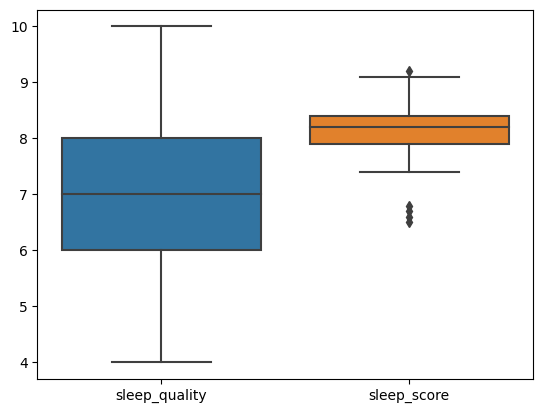

In [27]:
ax = sns.boxplot(data=df_full[['sleep_quality', 'sleep_score']])
ax.set_xticklabels(['sleep_quality', 'sleep_score'])
plt.show()

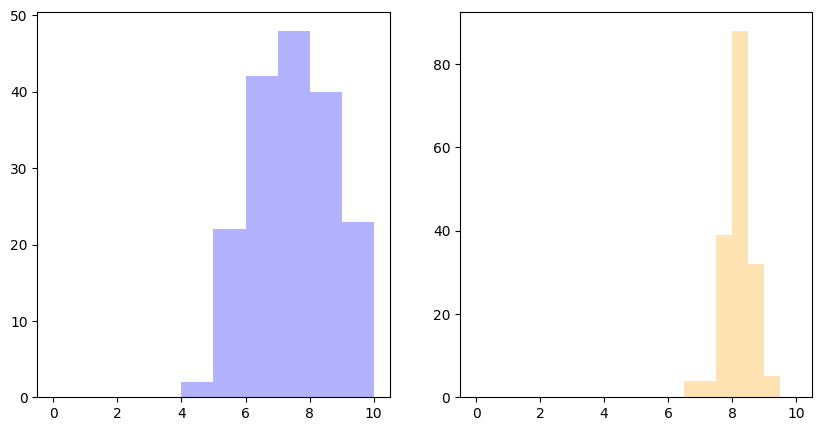

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].hist(df_full['sleep_quality'], color='blue', alpha=0.3, range=(0,10))
axes[1].hist(df_full['sleep_score'], color='orange', alpha=0.3, range=(0,10), bins=20)
plt.show()

На первый взгляд, моя субъективная оценка качества сна отличается от оценки фитнес-браслета. Проверим, насколько это разница статистически значима.

H0: оценки не отличаются.  
Ha: оценки отличаются.  
p = 0.05

Дисперсии у выборок отличаются; визуально распределения близки к нормальным.

In [29]:
stat, p = stats.normaltest(df_full['sleep_quality'], nan_policy='omit')
print(f"{p = }")
stat, p = stats.normaltest(df_full['sleep_score'], nan_policy='omit')
print(f"{p = }")

p = 0.025244186513850672
p = 2.6104710352478112e-06


Согласно тестам, распределение в выборках не нормальное, поэтому можно использовать Манна-Уитни

In [30]:
stat, p = stats.mannwhitneyu(df_full['sleep_quality'], df_full['sleep_score'], nan_policy='omit')
print(f'Statistics={stat:.3f}, p={p:.10f}')

Statistics=6374.500, p=0.0000000000


Т.к р-value близко к нулю, отклоняем нулевую гипотезу о том, что моя субъективная оценка качества сна не отличается от оценки фитнес-браслета. Соответственно, *sleep_score* не может заменить целевой показатель *sleep_quality*, и использование в анализе записей за 31.10.22 - 02.11.22 и 01.05.23 не имеет смысла.

In [31]:
df_full.drop(index=['2022-10-31', '2022-11-01', '2022-11-02', '2023-05-01'], axis=0, inplace=True)
df_full[df_full.isna().any(axis=1)]

,water_ml,coffee_ml,coffee_after_8pm,tea_ml,tea_after_8pm,last_meal_time,exercise,menstrual_cycle_day,atmospheric_pressure,sleep_quality,...,max_stress,steps,avg_spo2,min_heart_rate,avg_heart_rate,max_heart_rate,calories,wake_up_time,sleep_duration,sleep_score
date,,,,,,,,,,,,,,,,,,,,,
2023-04-14,1000.0,0.0,False,1200.0,True,2023-04-14 10:34:00,False,20.0,754.0,9.0,...,76.0,8182.0,93.0,55.0,87.0,133.0,549.0,NaT,NaN,NaN
2023-04-15,1200.0,0.0,False,1200.0,True,2023-04-15 21:05:00,True,21.0,759.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
2023-04-16,900.0,0.0,False,1200.0,True,2023-04-16 20:15:00,False,22.0,759.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
2023-04-17,900.0,500.0,True,1200.0,False,2023-04-17 21:03:00,False,23.0,758.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-04-18 07:00:00,375.0,8.1
2023-04-23,1200.0,1500.0,True,0.0,False,2023-04-23 23:46:00,False,1.0,757.0,7.0,...,82.0,401.0,93.0,57.0,87.0,122.0,344.0,NaT,NaN,NaN
2023-04-24,1200.0,1000.0,False,300.0,True,2023-04-24 23:33:00,False,2.0,755.0,6.0,...,83.0,3185.0,93.0,65.0,93.0,150.0,766.0,NaT,NaN,NaN
2023-04-25,1200.0,1000.0,False,600.0,True,2023-04-25 23:01:00,False,3.0,755.0,6.0,...,69.0,415.0,94.0,69.0,87.0,130.0,366.0,NaT,NaN,NaN
2023-04-26,900.0,1500.0,True,0.0,False,2023-04-26 21:21:00,False,4.0,754.0,6.0,...,77.0,752.0,93.0,64.0,90.0,137.0,592.0,NaT,NaN,NaN
2023-04-27,900.0,1000.0,False,0.0,False,2023-04-27 21:05:00,False,5.0,751.0,7.0,...,NaN,729.0,NaN,53.0,94.0,131.0,222.0,NaT,NaN,NaN


## EDA

Так как основная задача этого анализа - найти взаимосвязь в данных, начнем с pairplot.

In [32]:
df_full.columns

Index(['water_ml', 'coffee_ml', 'coffee_after_8pm', 'tea_ml', 'tea_after_8pm',
       'last_meal_time', 'exercise', 'menstrual_cycle_day',
       'atmospheric_pressure', 'sleep_quality', 'went_to_bed_time',
       'min_stress', 'avg_stress', 'max_stress', 'steps', 'avg_spo2',
       'min_heart_rate', 'avg_heart_rate', 'max_heart_rate', 'calories',
       'wake_up_time', 'sleep_duration', 'sleep_score'],
      dtype='object')

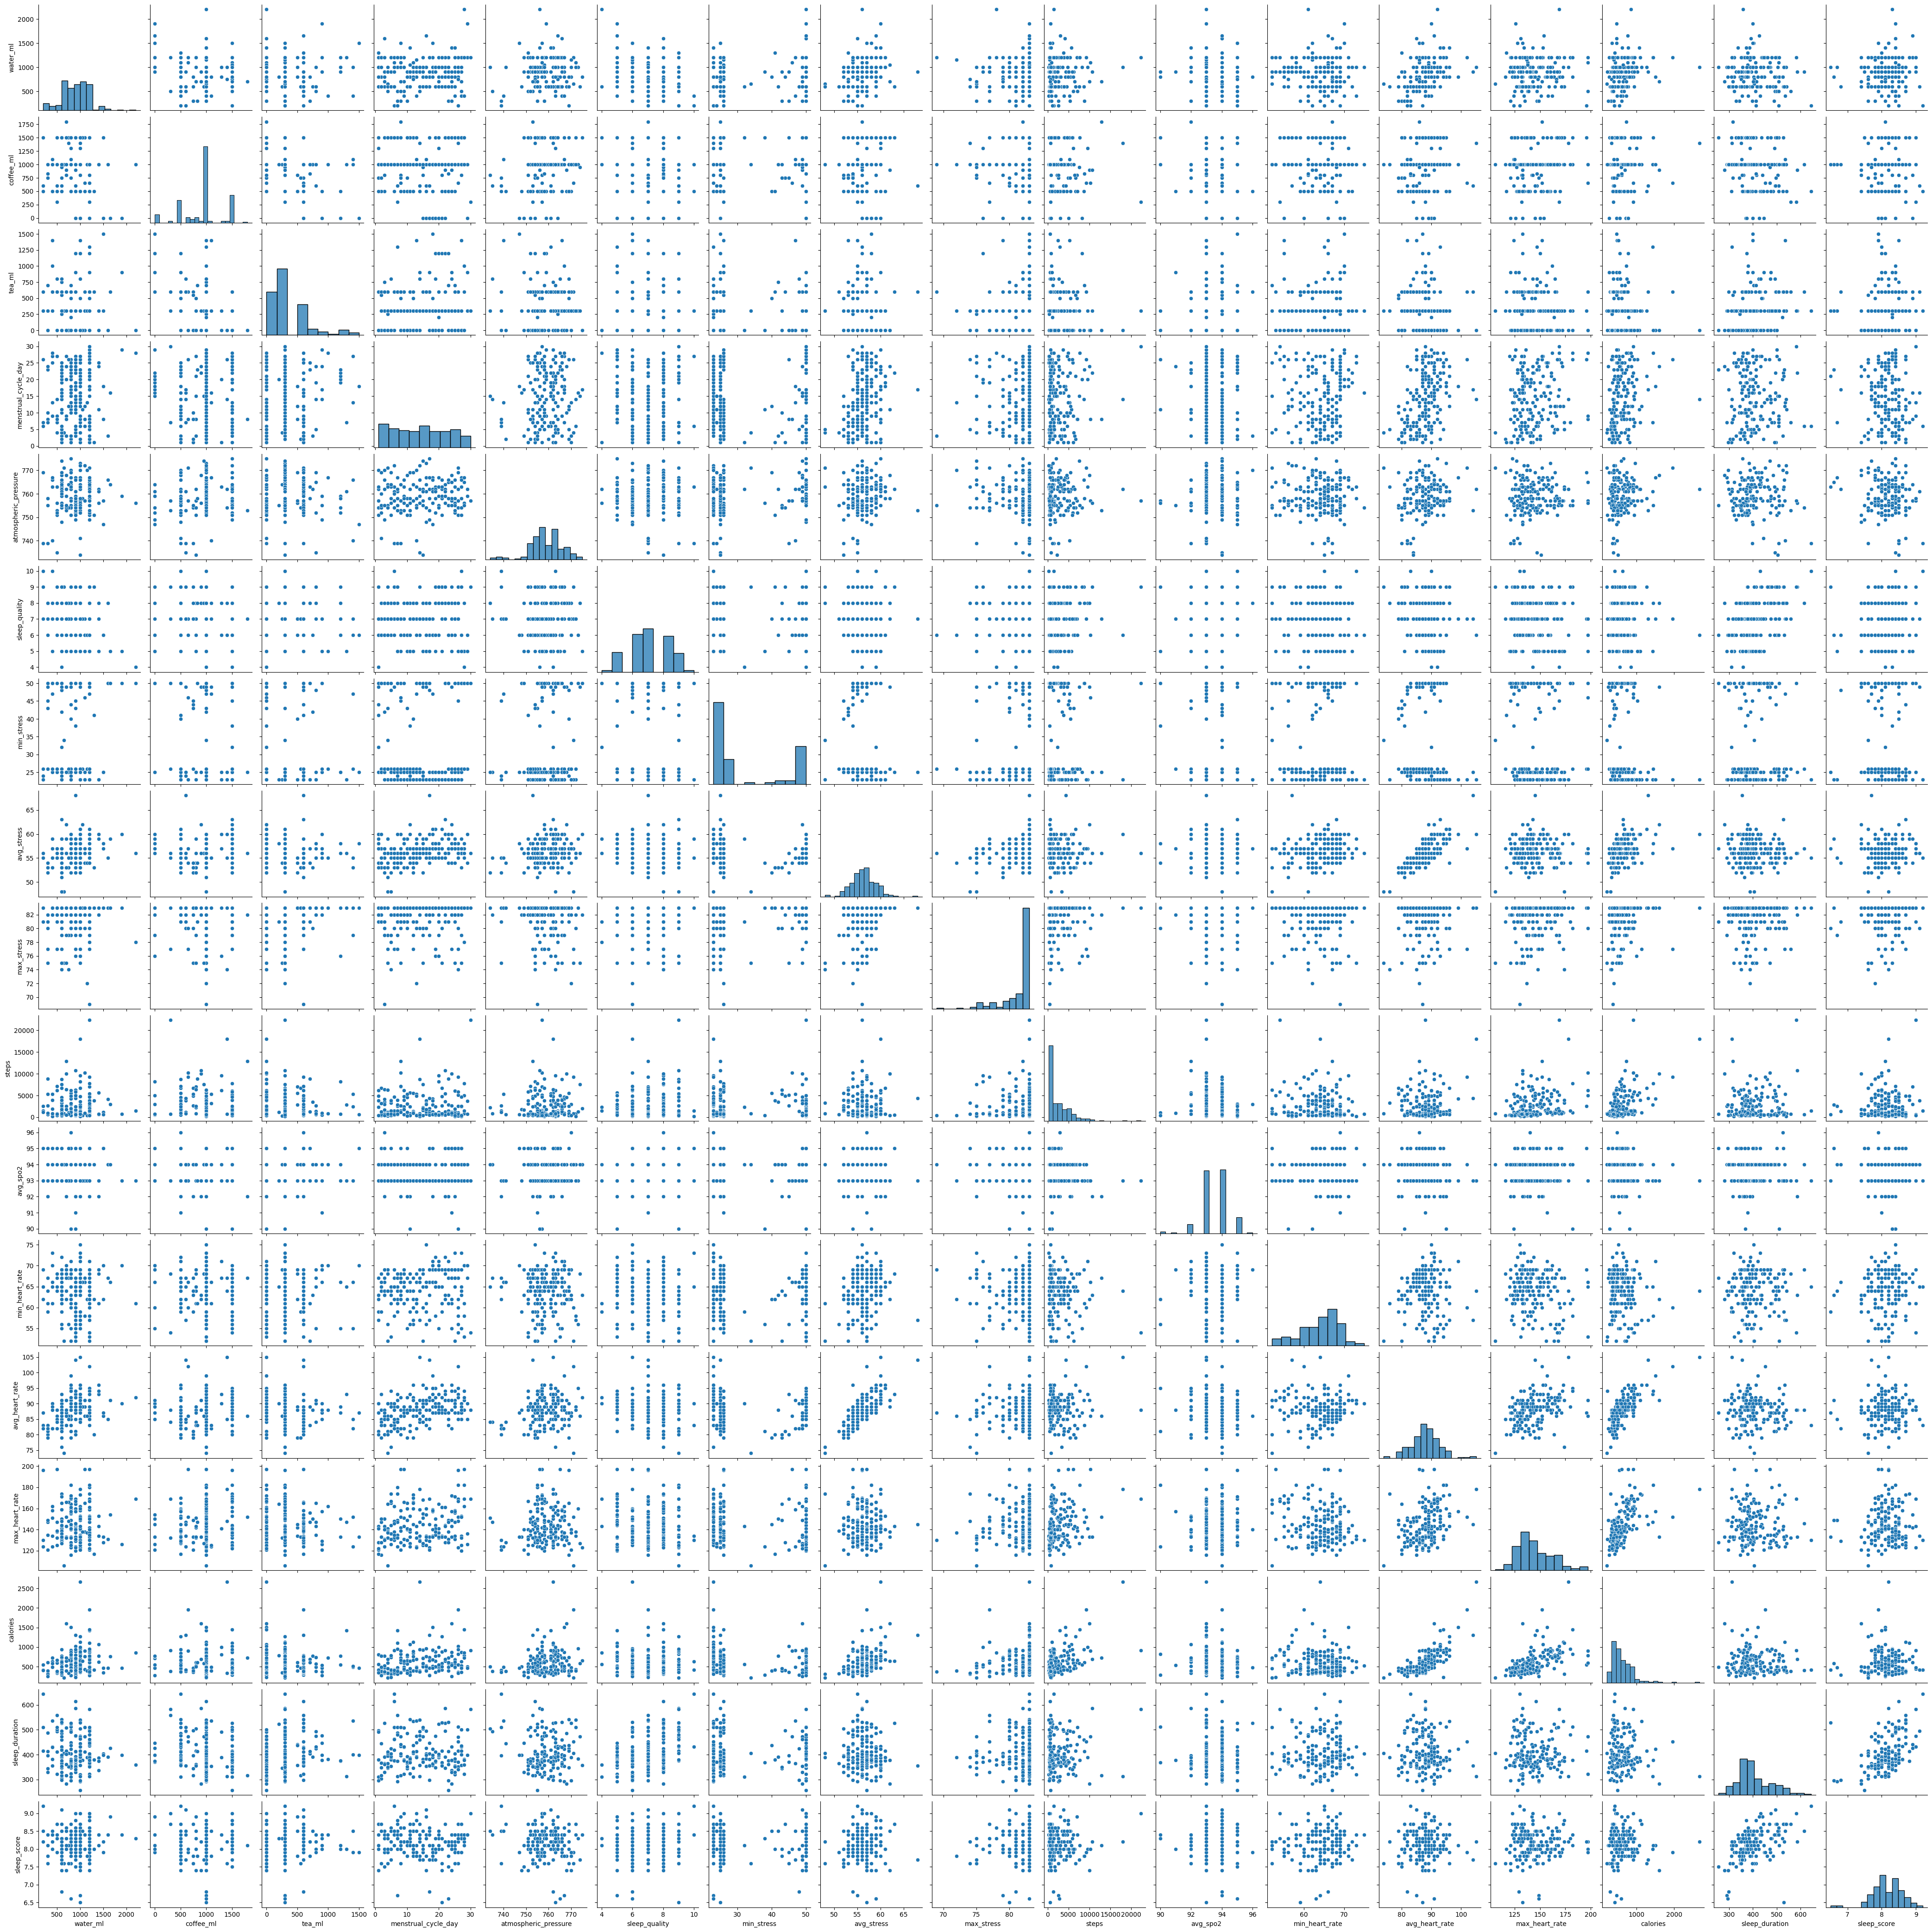

In [34]:
cols = ['water_ml', 'coffee_ml', 'tea_ml', 'menstrual_cycle_day', 'atmospheric_pressure', 'sleep_quality', 'min_stress', 'avg_stress', 'max_stress', 'steps', 
        'avg_spo2', 'min_heart_rate', 'avg_heart_rate', 'max_heart_rate', 'calories', 'sleep_duration', 'sleep_score']
sns.pairplot(df_full[cols])
plt.show()

Существует заметная связь между сожженными калориями, пройденными шагами и частотой сердцебиения, а также частотой сердцебиения и уровнем стресса.
Кроме того, существует положительная связь между длительностью сна и оценкой качества сна фитнес-браслетом.

Моя же оценкой качества сна ни от какого из параметров видимо не зависит.

Посмотрим более детально.

***
#### Начнем с кофе.

Предположительно, употребление большого количества кофе может негативно сказываться на качестве сна. Так как эффект от употребления или отказа от кофе может быть отсроченным, посмотрим на динамику показателей.

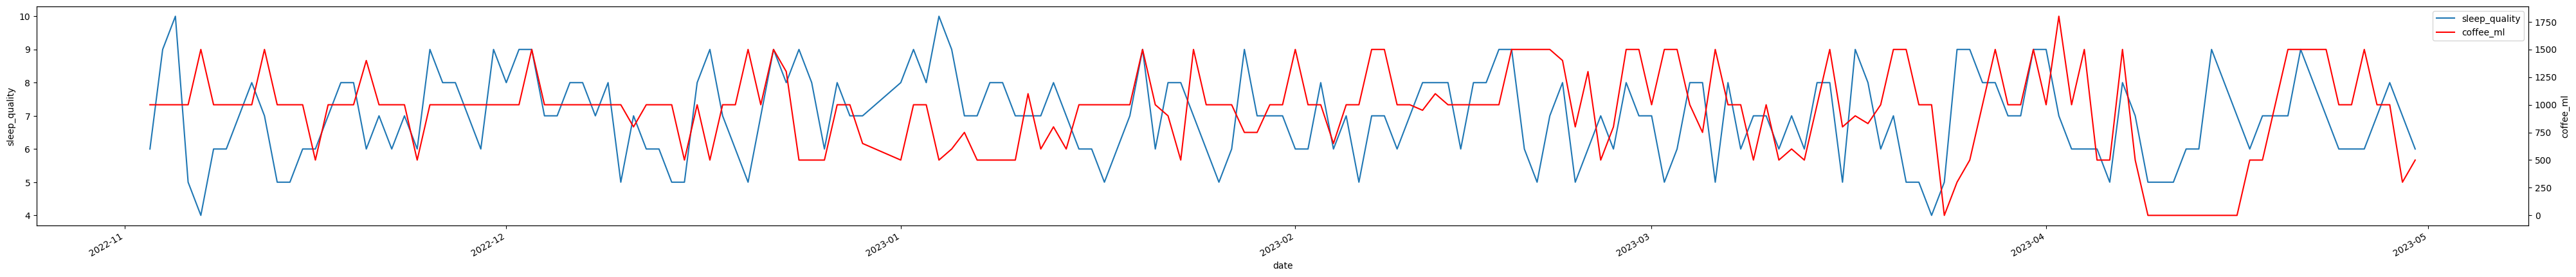

In [35]:
ax = df_full.plot(y='sleep_quality', legend=False, ylabel='sleep_quality', figsize=(50,5))
ax2 = ax.twinx()
df_full.plot(y='coffee_ml', ax=ax2, legend=False, ylabel='coffee_ml', color='r')
ax.figure.legend(bbox_to_anchor=(.90, 0.88))
plt.show()

В некоторых случаях, хоть и не во всех, увеличение или снижение количества выпитого кофе (красная линия) сопровождается ухудшением или улучшением соответственно качества сна через несколько дней (синяя линия).   
Тем не менее, также есть временные отрезки, когда качество сна заметно изменялось и при неизменном количестве выпитого кофе.

Изменятся ли показатели, если объединить кофе и чай? Ведь в чае также содержится достаточно кофеина.

In [36]:
coffee_tea = df_full[['sleep_quality', 'coffee_ml', 'tea_ml']].copy()
coffee_tea['caffeine'] = coffee_tea['coffee_ml'] + coffee_tea['tea_ml']
coffee_tea.head()

,sleep_quality,coffee_ml,tea_ml,caffeine
date,,,,
2022-11-03,6.0,1000.0,300.0,1300.0
2022-11-04,9.0,1000.0,300.0,1300.0
2022-11-05,10.0,1000.0,300.0,1300.0
2022-11-06,5.0,1000.0,600.0,1600.0
2022-11-07,4.0,1500.0,0.0,1500.0


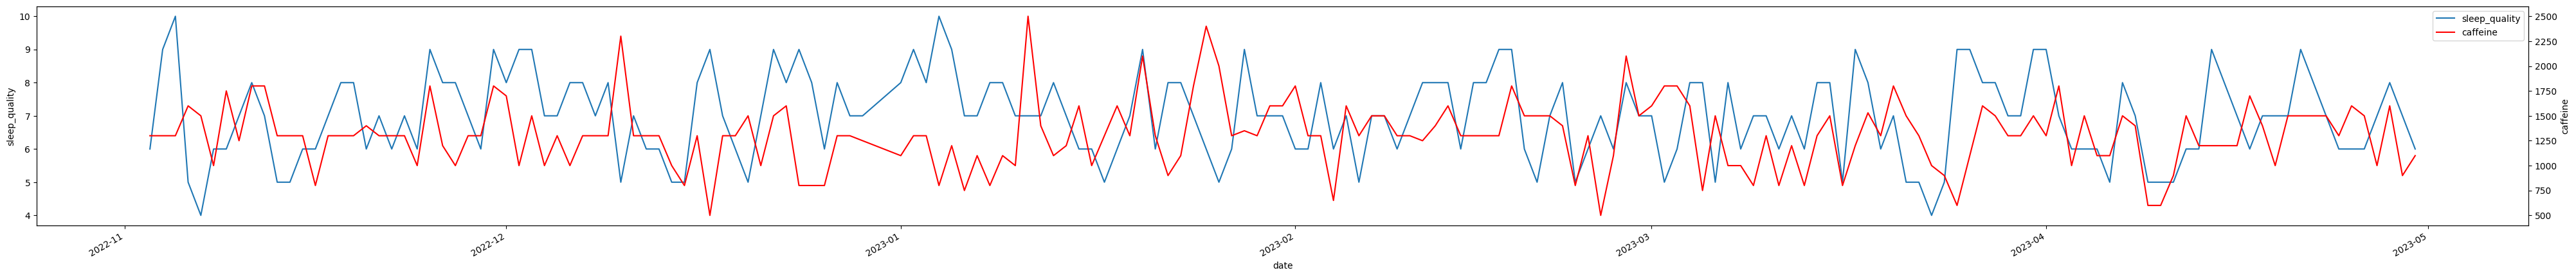

In [37]:
ax = coffee_tea.plot(y='sleep_quality', legend=False, ylabel='sleep_quality', figsize=(50,5))
ax2 = ax.twinx()
coffee_tea.plot(y='caffeine', ax=ax2, legend=False, ylabel='caffeine', color='r')
ax.figure.legend(bbox_to_anchor=(.90, 0.88))
plt.show()

Хотя в некоторых временных промежутках связь стала более заметной, в других она наоборот стала менее выраженной.

Возможно, важно не объем потребленных чая и кофе, а были ли они выпиты незадолго до сна.

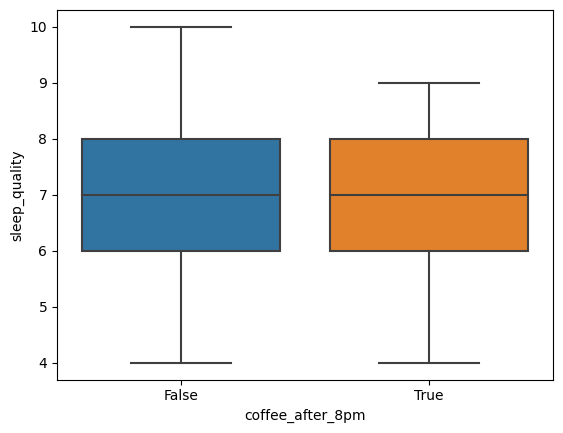

In [38]:
ax = sns.boxplot(data=df_full, x='coffee_after_8pm', y='sleep_quality')
plt.show()

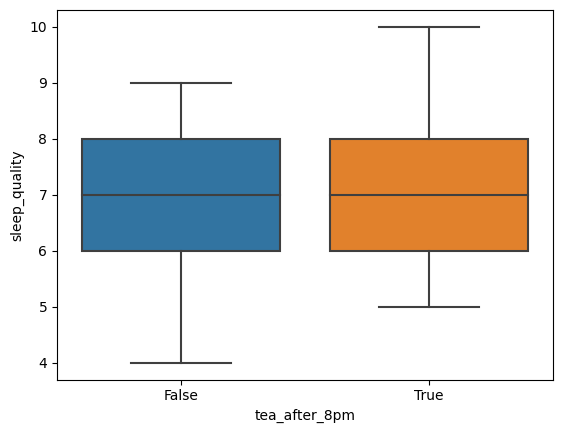

In [39]:
ax = sns.boxplot(data=df_full, x='tea_after_8pm', y='sleep_quality')
plt.show()

Заметной разницы в данных не наблюдается.

Известно также, что чай и кофе выводят из организма воду. Возможно эффект чая и кофе на сон зависит также от выпитой в этот день воды.

In [40]:
cofteawat = df_full[['sleep_quality', 'coffee_ml', 'tea_ml', 'water_ml']].copy()
cofteawat['caffeine_minus_water'] = cofteawat['coffee_ml'] + cofteawat['tea_ml'] - cofteawat['water_ml']
cofteawat.head()

,sleep_quality,coffee_ml,tea_ml,water_ml,caffeine_minus_water
date,,,,,
2022-11-03,6.0,1000.0,300.0,1000.0,300.0
2022-11-04,9.0,1000.0,300.0,800.0,500.0
2022-11-05,10.0,1000.0,300.0,400.0,900.0
2022-11-06,5.0,1000.0,600.0,1200.0,400.0
2022-11-07,4.0,1500.0,0.0,600.0,900.0


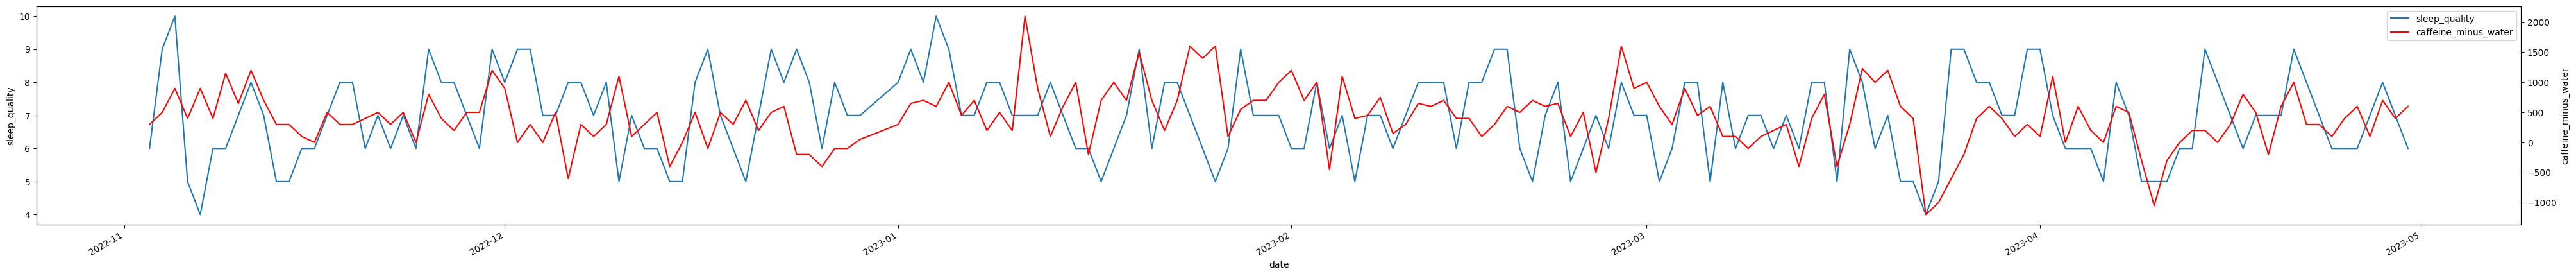

In [41]:
ax = cofteawat.plot(y='sleep_quality', legend=False, ylabel='sleep_quality', figsize=(50,5))
ax2 = ax.twinx()
cofteawat.plot(y='caffeine_minus_water', ax=ax2, legend=False, ylabel='caffeine_minus_water', color='r')
ax.figure.legend(bbox_to_anchor=(.90, 0.88))
plt.show()

Снова, в некоторых временных промежутках связь стала более заметной, в других она наоборот стала менее выраженной.

***
#### Совы и жаворонки

Другим логичным фактором, влияющим на качество сна, является время засыпания и пробуждения, а также длительность сна.

Начнем с длительности.

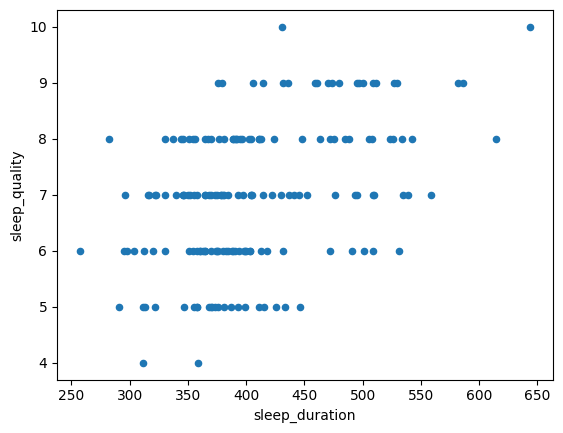

In [42]:
df_full.plot(kind='scatter', x='sleep_duration', y='sleep_quality')
plt.show()

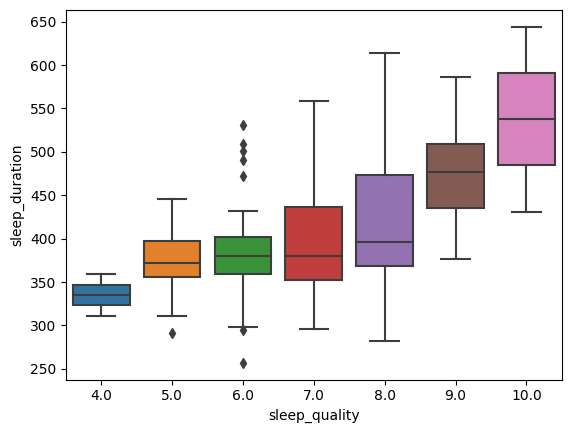

In [43]:
sns.boxplot(data=df_full, y='sleep_duration', x='sleep_quality')
plt.show()

Судя по боксплоту, между продолжительностью сна и его качеством действительно может существовать связь.

In [44]:
values = []
names = []

for_oneway = []

for mark in sorted(df_full['sleep_quality'].unique()):
    vals = list(df_full[df_full['sleep_quality']==mark]['sleep_duration'].dropna())
    values += vals
    names += [mark] * len(vals)

    for_oneway.append(vals)

tukey = pairwise_tukeyhsd(endog=values, groups=names, alpha=0.05)
print(tukey)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper   reject
-------------------------------------------------------
   4.0    5.0  37.9091  0.983 -100.7634 176.5816  False
   4.0    6.0  48.7179 0.9364  -87.4126 184.8485  False
   4.0    7.0  64.4444 0.7914  -71.2427 200.1316  False
   4.0    8.0  84.2308 0.5182  -51.8998 220.3613  False
   4.0    9.0   141.15 0.0447    1.9009 280.3991   True
   4.0   10.0    202.5 0.0255   14.7366 390.2634   True
   5.0    6.0  10.8089 0.9952  -39.2559  60.8736  False
   5.0    7.0  26.5354 0.6684  -22.3109  75.3816  False
   5.0    8.0  46.3217 0.0899   -3.7431  96.3865  False
   5.0    9.0 103.2409    0.0     45.23 161.2518   True
   5.0   10.0 164.5909 0.0091   25.9184 303.2634   True
   6.0    7.0  15.7265 0.9137  -25.3518  56.8048  False
   6.0    8.0  35.5128 0.1685   -7.0072  78.0329  False
   6.0    9.0  92.4321    0.0   40.7916 144.0725   True
   6.0   10.0 153.7821 0.0159   17.6515 289.9126

In [45]:
fval2, pval2 = stats.f_oneway(*for_oneway)
print(f"Статистика = {fval2:.5f}, p = {pval2:.5f}")

Статистика = 8.22526, p = 0.00000


Исходя из тестов, есть статистически значимая разница в длительности сна для групп с разной оценкой качества сна. Большая продолжительность сна часто означает выше его качество. 

Как насчет времени засыпания?

Сначала выделим из колонки *went_to_bed_time* время, так как дата в этом случае не имеет значения.

In [46]:
bedtime = df_full[['sleep_quality', 'went_to_bed_time', 'wake_up_time']].copy().dropna()

bedtime['went_to_bed_time'] = bedtime['went_to_bed_time'].dt.hour*60 + bedtime['went_to_bed_time'].dt.minute
bedtime['went_to_bed_time'][bedtime['went_to_bed_time'] > 720] = bedtime['went_to_bed_time'] - 1440

bedtime['wake_up_time'] = bedtime['wake_up_time'].dt.hour*60 + bedtime['wake_up_time'].dt.minute
bedtime.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 169 entries, 2022-11-03 to 2023-04-30
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sleep_quality     169 non-null    float64
 1   went_to_bed_time  169 non-null    int32  
 2   wake_up_time      169 non-null    int32  
dtypes: float64(1), int32(2)
memory usage: 4.0 KB


C:\Users\lina1\AppData\Local\Temp\ipykernel_5996\3689585794.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bedtime['went_to_bed_time'][bedtime['went_to_bed_time'] > 720] = bedtime['went_to_bed_time'] - 1440


In [47]:
bedtime.sort_values('went_to_bed_time', inplace=True)

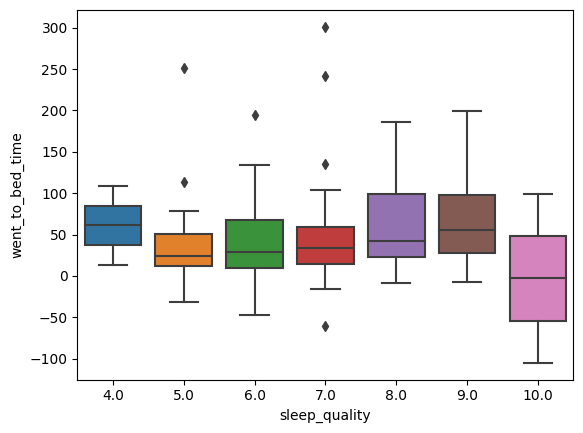

In [48]:
sns.boxplot(data=bedtime, y='went_to_bed_time', x='sleep_quality')
plt.show()

In [49]:
values = []
names = []

for_oneway = []

for mark in sorted(bedtime['sleep_quality'].unique()):
    vals = list(bedtime[bedtime['sleep_quality']==mark]['went_to_bed_time'].dropna())
    values += vals
    names += [mark] * len(vals)

    for_oneway.append(vals)

tukey = pairwise_tukeyhsd(endog=values, groups=names, alpha=0.05)
print(tukey)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper   reject
-------------------------------------------------------
   4.0    5.0 -21.7273 0.9986 -146.8929 103.4383  False
   4.0    6.0  -20.359 0.9989 -143.2302 102.5123  False
   4.0    7.0 -14.6889 0.9998 -137.1599 107.7821  False
   4.0    8.0   0.4872    1.0 -122.3841 123.3584  False
   4.0    9.0      6.6    1.0  -119.086  132.286  False
   4.0   10.0    -64.0 0.9188  -233.475  105.475  False
   5.0    6.0   1.3683    1.0  -43.8201  46.5567  False
   5.0    7.0   7.0384 0.9991  -37.0501  51.1269  False
   5.0    8.0  22.2145 0.7634   -22.974  67.4029  False
   5.0    9.0  28.3273 0.6727  -24.0333  80.6878  False
   5.0   10.0 -42.2727 0.9515 -167.4383  82.8929  False
   6.0    7.0   5.6701 0.9993  -31.4071  42.7473  False
   6.0    8.0  20.8462 0.6685  -17.5324  59.2247  False
   6.0    9.0   26.959 0.5991  -19.6516  73.5695  False
   6.0   10.0  -43.641 0.9386 -166.5123  79.2302

In [50]:
fval2, pval2 = stats.f_oneway(*for_oneway)
print(f"Статистика = {fval2:.5f}, p = {pval2:.5f}")

Статистика = 1.22839, p = 0.29435


Исходя из тестов, нет статистически значимой разницы во времени засыпания для групп с разной оценкой качества сна.
Видимо, не так важно, в какое время я легла спать при условии, что я спала достаточно долго.

***
#### Питание и физические нагрузки

Посмотрим, влияет ли режим питания и тренировок на качество сна.

Начнем с питания. Предположительно, поздний прием пищи приводит к ухудшению сна.

In [58]:
food = df_full[['last_meal_time', 'sleep_quality']].copy().dropna()

food['last_meal_time'] = food['last_meal_time'].dt.hour*60 + food['last_meal_time'].dt.minute
food.head()

,last_meal_time,sleep_quality
date,,
2022-11-03,1194,6.0
2022-11-04,1355,9.0
2022-11-05,1402,10.0
2022-11-06,1160,5.0
2022-11-07,1303,4.0


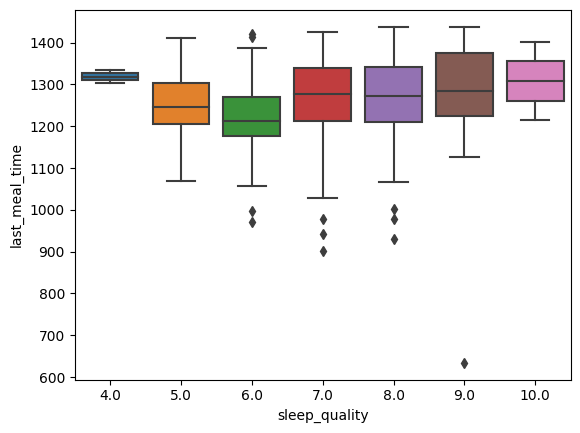

In [60]:
sns.boxplot(data=food, y='last_meal_time', x='sleep_quality')
plt.show()

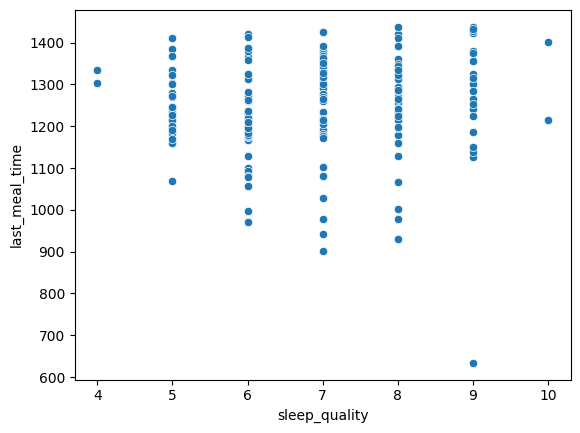

In [62]:
sns.scatterplot(data=food, y='last_meal_time', x='sleep_quality')
plt.show()

In [61]:
values = []
names = []

for mark in sorted(food['sleep_quality'].unique()):
    vals = list(food[food['sleep_quality']==mark]['last_meal_time'].dropna())
    values += vals
    names += [mark] * len(vals)

tukey = pairwise_tukeyhsd(endog=values, groups=names, alpha=0.05)
print(tukey)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower    upper   reject
--------------------------------------------------------
   4.0    5.0  -63.2727 0.9908 -323.4263 196.8809  False
   4.0    6.0 -100.2619 0.9032 -355.2015 154.6777  False
   4.0    7.0  -63.2292 0.9897 -317.4434 190.9851  False
   4.0    8.0    -61.65 0.9912 -316.8791 193.5791  False
   4.0    9.0  -55.7143 0.9954 -316.3835  204.955  False
   4.0   10.0     -11.0    1.0 -363.2496 341.2496  False
   5.0    6.0  -36.9892 0.8969 -129.6945  55.7161  False
   5.0    7.0    0.0436    1.0  -90.6482  90.7353  False
   5.0    8.0    1.6227    1.0  -91.8759  95.1213  False
   5.0    9.0    7.5584    1.0  -99.9058 115.0226  False
   5.0   10.0   52.2727 0.9968 -207.8809 312.4263  False
   6.0    7.0   37.0327 0.7535  -37.3936 111.4591  False
   6.0    8.0   38.6119  0.756  -39.2102  116.434  False
   6.0    9.0   44.5476 0.7948  -49.5951 138.6903  False
   6.0   10.0   89.2619 0.9427 

Как визуализации, так и тесты не показали зависимости качества сна от времени последнего приема пищи.

Теперь посмотрим на физические нагрузки.  
Здесь можно рассматривать разные показатели: *exercise*, *steps*, *calories*.  
Начнем со сравнения дней с тренировками и без них.

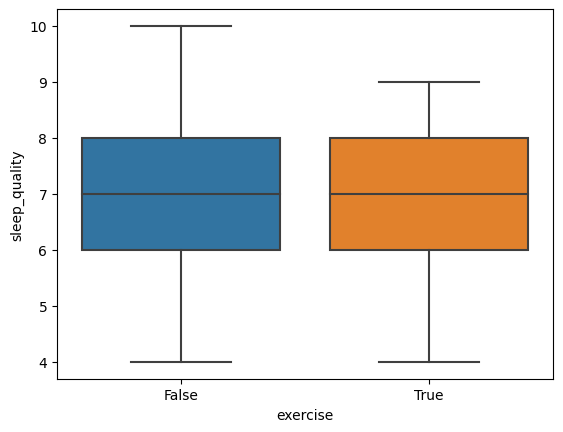

In [64]:
sns.boxplot(data=df_full, x='exercise', y='sleep_quality')
plt.show()

Визуально большой разницы не заметно. Посмотрим есть ли статистически значимые различия.

H0: различий нет.  
Ha: различия есть.  
p = 0.05

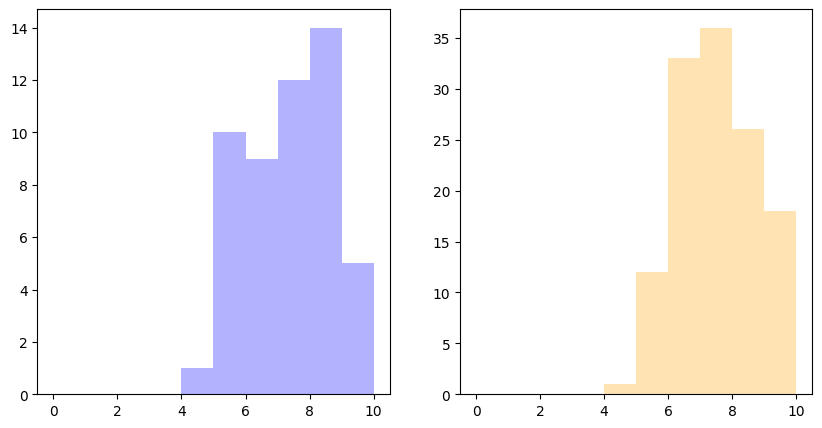

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].hist(df_full[df_full['exercise']==True]['sleep_quality'], color='blue', alpha=0.3, range=(0,10))
axes[1].hist(df_full[df_full['exercise']==False]['sleep_quality'], color='orange', alpha=0.3, range=(0,10))
plt.show()

Дисперсии у выборок не отличаются; визуально распределения близки к нормальным.

In [69]:
stat, p = stats.normaltest(df_full[df_full['exercise']==True]['sleep_quality'], nan_policy='omit')
print(f"{p = }")
stat, p = stats.normaltest(df_full[df_full['exercise']==False]['sleep_quality'], nan_policy='omit')
print(f"{p = }")

p = 0.04178152536451419
p = 0.18118212101010508


Согласно тестам, распределение в одной из выборок не нормальное, поэтому можно использовать Манна-Уитни

In [70]:
stat, p = stats.mannwhitneyu(df_full[df_full['exercise']==True]['sleep_quality'], df_full[df_full['exercise']==False]['sleep_quality'], nan_policy='omit')
print(f'Statistics={stat:.3f}, p={p:.10f}')

Statistics=3014.000, p=0.5098372173


Значение p-value не позволяет отклонить нулевую гипотезу. Статистически значимых различий между днями с физическими нагрузками и без них нет.

Теперь посмотрим на шаги и сожженные калории.

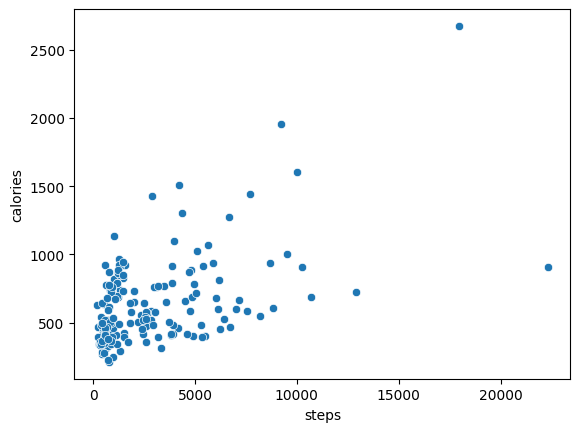

In [71]:
sns.scatterplot(data=df_full, x='steps', y='calories')
plt.show()

In [72]:
df_full[['steps', 'calories']].corr()

,steps,calories
steps,1.000000,0.531904
calories,0.531904,1.000000


Между пройденными шагами и сожженным калориями есть положительная корреляция, но так как она не сильная, проверим влияние каждого из этих факторов.

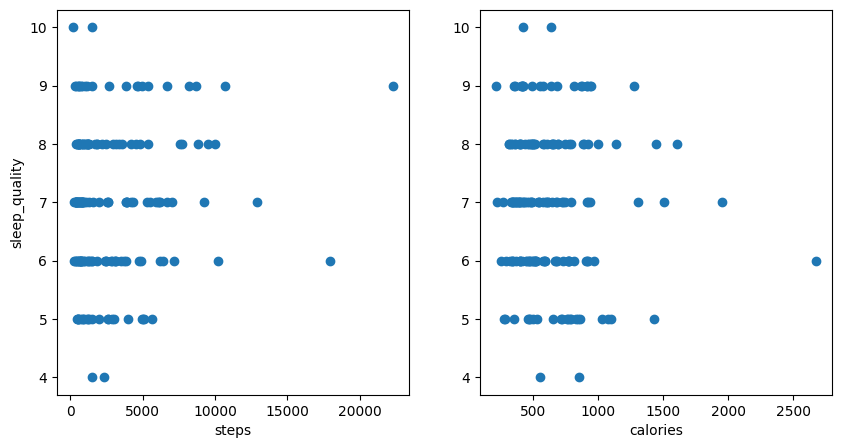

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].scatter(x=df_full['steps'], y=df_full['sleep_quality'])
axes[0].set_xlabel('steps')
axes[0].set_ylabel('sleep_quality')

axes[1].scatter(x=df_full['calories'], y=df_full['sleep_quality'])
axes[1].set_xlabel('calories')
plt.show()

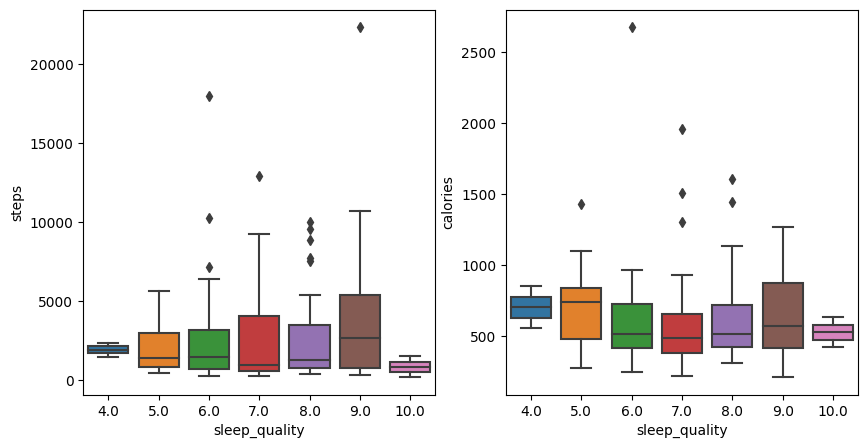

In [81]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

sns.boxplot(data=df_full, x='sleep_quality', y='steps', ax=axes[0])
axes[0].set_ylabel('steps')
axes[0].set_xlabel('sleep_quality')

sns.boxplot(data=df_full, x='sleep_quality', y='calories', ax=axes[1])
axes[1].set_ylabel('calories')
plt.show()

Визуально, разницы между группами не заметно.

***
#### Другие факторы

Уровень стресса

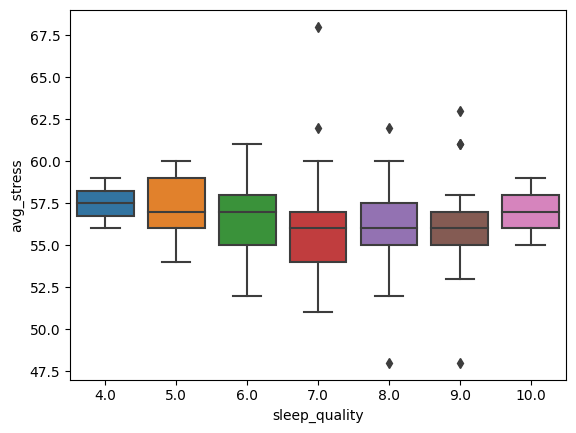

In [87]:
sns.boxplot(data=df_full, y='avg_stress', x='sleep_quality')
plt.show()

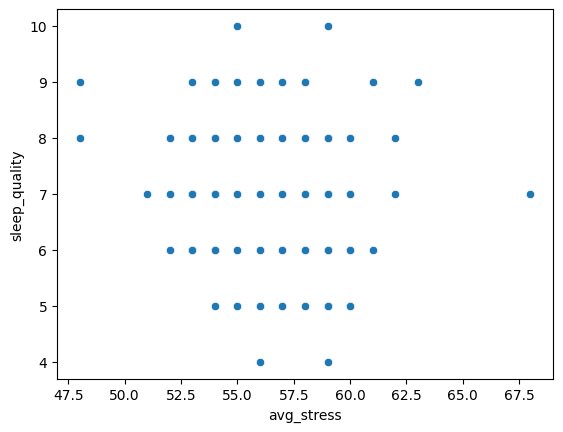

In [88]:
sns.scatterplot(data=df_full, x='avg_stress', y='sleep_quality')
plt.show()

Визуально, больших различий в группах не наблюдается.

Атмосферное давление

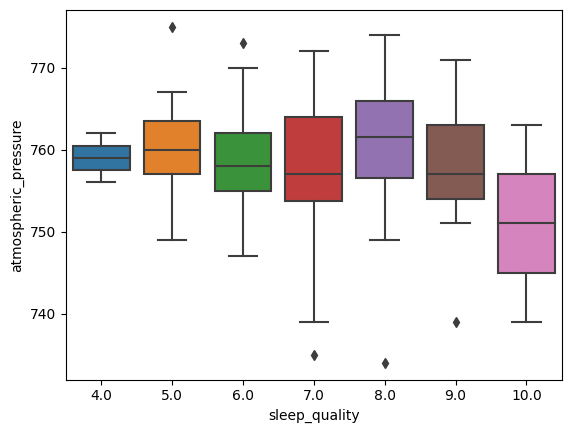

In [90]:
sns.boxplot(data=df_full, y='atmospheric_pressure', x='sleep_quality')
plt.show()

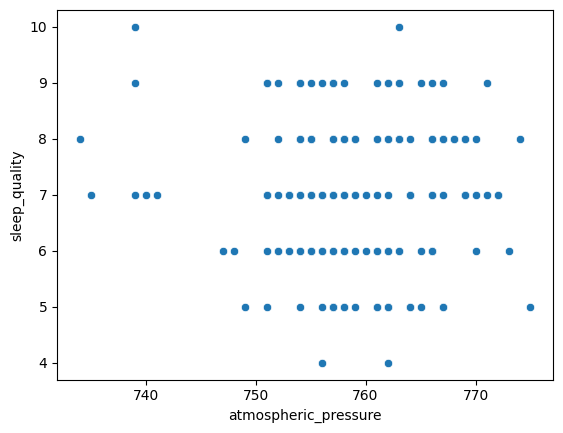

In [91]:
sns.scatterplot(data=df_full, x='atmospheric_pressure', y='sleep_quality')
plt.show()

Судя по графикам, при низком атмосферном давлении качество сна в среднем выше, однако это вполне может быть связано с тем, что низкие показатели атмосферного давления редко встречаются в выборке.

Менструальный цикл

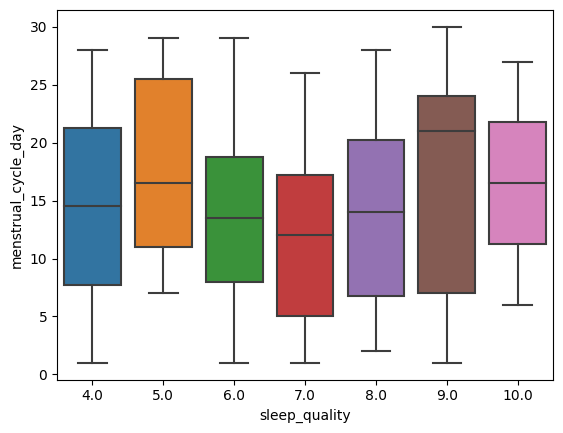

In [93]:
sns.boxplot(data=df_full, y='menstrual_cycle_day', x='sleep_quality')
plt.show()

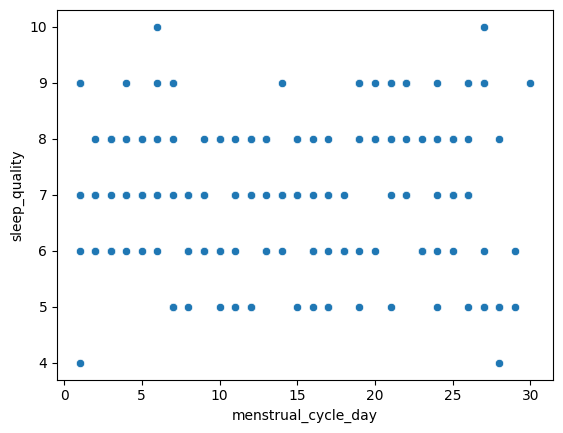

In [94]:
sns.scatterplot(data=df_full, x='menstrual_cycle_day', y='sleep_quality')
plt.show()

Визуально, больших различий в группах не наблюдается.

### Выводы

Анализ собранных данных привел меня к выводам, которые я так не хотела признавать ~~(чтобы опровергнуть эти выводы сам анализ и затевался 😄)~~: чтобы лучше высыпаться, нужно спать достаточное количество времени и, возможно(!) ~~(я все еще не готова признать это из-за моей огромной любви к кофе)~~ быть осторожней с напитками, содержащими кофеин.